## PySpark ##
Que es?
PySpark es una combinación de una API de Python y el motor de Apache Spark, el cual se utiliza para el análisis de grandes volúmenes de datos mediante un procesamiento distribuido en clústeres que se ejecutan en paralelo. En resumen, PySpark es una herramienta que nos permite interactuar con Spark utilizando Python.

Primero, crearemos una instancia para la conexion con spark, crearemos una session y la configuraremos a las caracteristicas que se necesite

In [22]:
from pyspark.sql import SparkSession #libreria para crear una sesion

#generar una session con spark
spark = SparkSession.builder \
    .appName("MiAppLocal") \
    .master("local[*]") \
    .getOrCreate()

print(spark)

Al crear la sesion de spark, tambien se puede configurar la cantidad de cores, la cantidad de memoria a cada ejecutor, y la memoria del cluster principal, pero como en este caso como es un entorno local, dejaremos que spark lo configure para evitar sobrepasar las limitaciones del hardware

Ahora, procederemos con la lectura del archivo a procesar y a pasarselo a spark. en este caso leeremos un txt y y se lo pasamos a spark

In [23]:
#le pasamos el archivo a spark.
data = spark.read.text('prueba.txt')


Ahora, eliminamos los caracteres especiales y ponemos a minusculas todo el contenido del texto usando ya la variable de spark

In [24]:
#estas funciones proporcionan manejo sobre los datos
from pyspark.sql.functions import col, lower, regexp_replace


# Preprocesar el texto: Convertir a minúsculas y eliminar caracteres especiales
cleaned_data = data.select(
    regexp_replace(lower(col("value")), r"[^a-zA-Z0-9\s]", "").alias("value")
)

print(cleaned_data)

DataFrame[value: string]


Ahora, el siguiente paso es dividir todo el contenido en palabras por separado usando split,y luego la funcion explode de usa  para distribuir todas las palabras en filas por separado.

In [25]:
#funciones para manejo de datos
from pyspark.sql.functions import  explode, split

# Dividir el texto en palabras
words = cleaned_data.select(
    explode( #generar filas con cada palabra
        split(col("value"), r"\s+") #separar todas las palabras mediante espacios vacios
    ).alias("word")
).filter(col("word") != "")  # Filtrar palabras vacías

print(words)

DataFrame[word: string]


Para hacer una limpieza de palabras, eliminaremos los stop words de la siguiente manera

In [26]:

from nltk.corpus import stopwords

# Descargar stopwords de nltk (solo es necesario la primera vez)
import nltk

nltk.download('stopwords')

# Cargar las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Filtrar stopwords
filtered_words = words.filter(~col("word").isin(stop_words))

print(filtered_words)

[nltk_data] Downloading package stopwords to C:\Users\MARTHA ISABEL
[nltk_data]     VILLAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


DataFrame[word: string]


Para casi finalizar el proceso, extraeremos las 20 palabras mas frecuentes de todo el contenido 

In [27]:
# Contar la frecuencia de las palabras
word_counts = filtered_words.groupBy("word").count().orderBy(col("count").desc())

# Convertir el resultado a un dataframe para la visualización
top_words = word_counts.limit(20).toPandas()

print(top_words)

            word  count
0          ebook      5
1         united      4
2         states      4
3              1      3
4        america      2
5        located      2
6        project      2
7   independence      2
8    declaration      2
9      gutenberg      2
10        online      1
11         parts      1
12        anyone      1
13          copy      1
14         using      1
15          1971      1
16      recently      1
17         title      1
18         terms      1
19        author      1


Y para graficar la frecuencia de las palabras, generaremos una nube de palabras

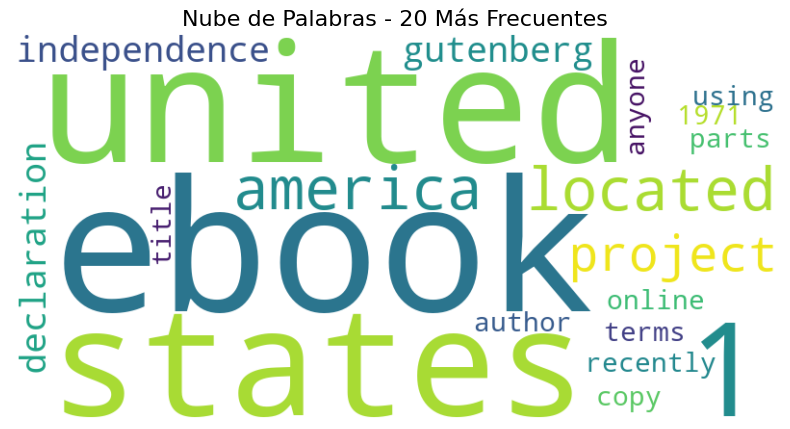

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# Crear un diccionario con las palabras y sus frecuencias
word_freq = dict(zip(top_words['word'], top_words['count']))

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de Palabras - 20 Más Frecuentes", fontsize=16)
plt.show()

# Detener la sesión de Spark
spark.stop()